## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Чапаев Артем Юрьевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1 Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last = True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

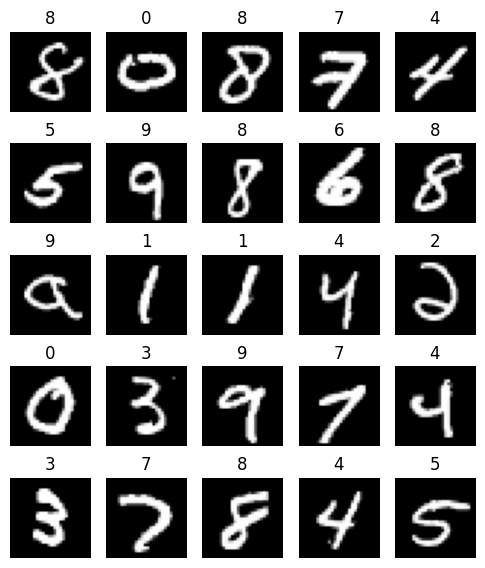

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

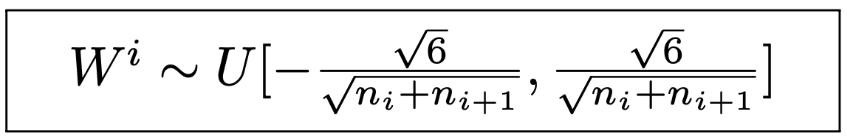

Посмотрим на дисперсию, когда параметры инициализируются из распределения N(0,1) и функция активации nn.Tanh()

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9800777435302734
forward 0.9836893677711487
backward 0.04472136124968529
backward 0.017624715343117714


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Посмотрим на дисперсию в случае инициализации He, но функции активации nn.Tanh()

In [8]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0.0, 2 / 784)
init_layer(layer_2, 0.0, 2 / 500)

network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9800777435302734
forward 0.0411631315946579
backward 0.04472136124968529
backward 0.0007878092583268881


Теперь испольузем инициализацию Xavier

In [9]:
def init_layer_uniform(layer, a, b):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(a, b)

In [10]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer_uniform(layer_1, -(6 / (28*28 + 500))**0.5, (6 / (28*28 + 500))**0.5)
init_layer_uniform(layer_2, -(6 / (500 + 10))**0.5, (6 / (500 + 10))**0.5)

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9800777435302734
forward 0.6383345723152161
backward 0.04472136124968529
backward 0.013404431752860546


Таким образом, Xavier подобно He уменьшает дисперсию и делает ее более контролируемой

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

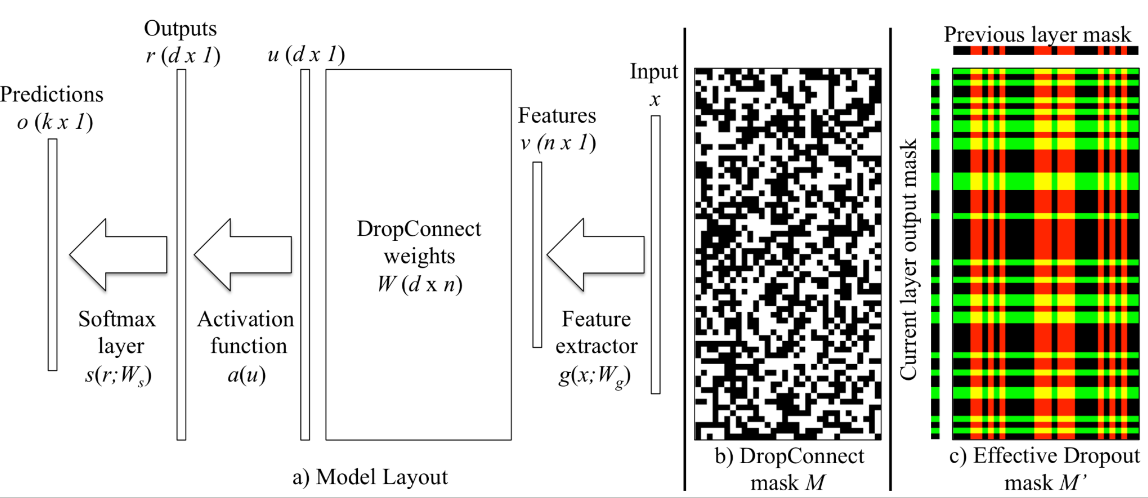

In [11]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.empty(self.linear.weight.shape).bernoulli_(self.p).type(torch.FloatTensor)
        if not self.training:
            mask = torch.where(mask == 1, 1, 1 - self.p)

        mask = mask.data.requires_grad_(False)
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output



#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Основа для сети, которую будем обучать:

In [12]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [13]:
def train(network, optimizer):
    test_losses = []
    train_losses = []
    
    for epoch in range(10):
        network.train()
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
    
            if batch_idx % 100 == 0:
                train_losses.append(loss.item())
    
        network.eval()
        losses = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)
    
            losses.append(loss.item())
    
        test_losses.append(np.mean(losses))
    return train_losses, test_losses    

#### Dropout

In [14]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask
    
    
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

dropout_train_losses, dropout_test_losses = train(network, optimizer)

#### DropConnection

In [15]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.empty(self.linear.weight.shape).bernoulli_(self.p).type(torch.FloatTensor)
        if not self.training:
            mask = torch.where(mask == 1, 1, 1 - self.p)

        mask = mask.data.requires_grad_(False)
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output
    
    
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128 , 10),
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

dropConnection_train_losses, dropConnection_test_losses = train(network, optimizer)

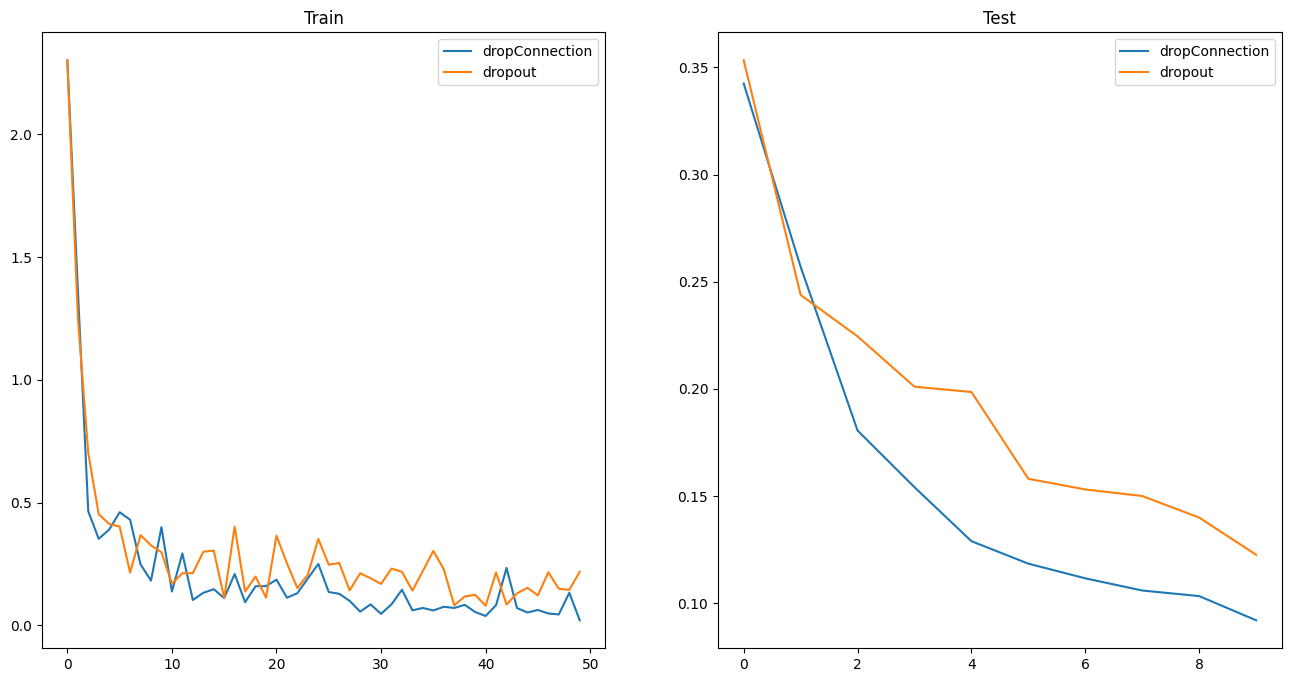

In [16]:
x1 = range(len(dropConnection_train_losses))
x2 = range(len(dropConnection_test_losses))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(x1, dropConnection_train_losses, label='dropConnection')
ax1.plot(x1, dropout_train_losses, label='dropout')
ax1.set_title('Train')
ax1.legend()

ax2.plot(x2, dropConnection_test_losses, label='dropConnection')
ax2.plot(x2, dropout_test_losses, label='dropout')
ax2.set_title('Test')
ax2.legend()

plt.show()

Таким образом, на графиках видно, что на тесте в данном случае dropConnection показывает результат лучше, чем dropout.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

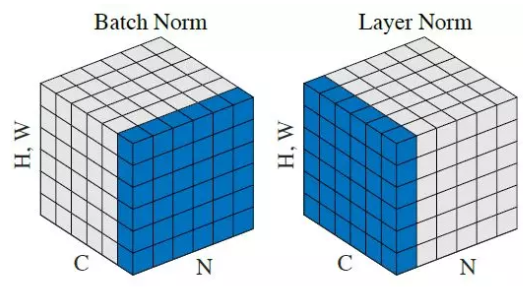

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [17]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, size=128):
        super().__init__()
        
        self.shape = (size, 1, 1, 1)
        
        self.weights = torch.ones(self.shape, requires_grad=True)
        self.biases = torch.zeros(self.shape, requires_grad=True)
        
    
    def forward(self, x):
        std = x.std(dim=(1,2,3)).reshape(self.shape)
        mean = x.mean(dim=(1,2,3)).reshape(self.shape)

        output = (x - mean) / std
        output = output * self.weights + self.biases

        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [18]:
class TestNetwork(nn.Module):
    def __init__(self, conv_layers, final_part):
        super().__init__()

        self.conv_layers = conv_layers

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [19]:
layers = nn.Sequential(
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [20]:
conv_layers = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),
            nn.BatchNorm2d(2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

network = TestNetwork(conv_layers, layers)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

batchNorm_train_losses, batchNorm_test_losses = train(network, optimizer)

In [21]:
conv_layers = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),
            LayerNormalization(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            LayerNormalization(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(4, 4, 3, padding=1),
        )

network = TestNetwork(conv_layers, layers)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

layerNorm_train_losses, layerNorm_test_losses = train(network, optimizer)

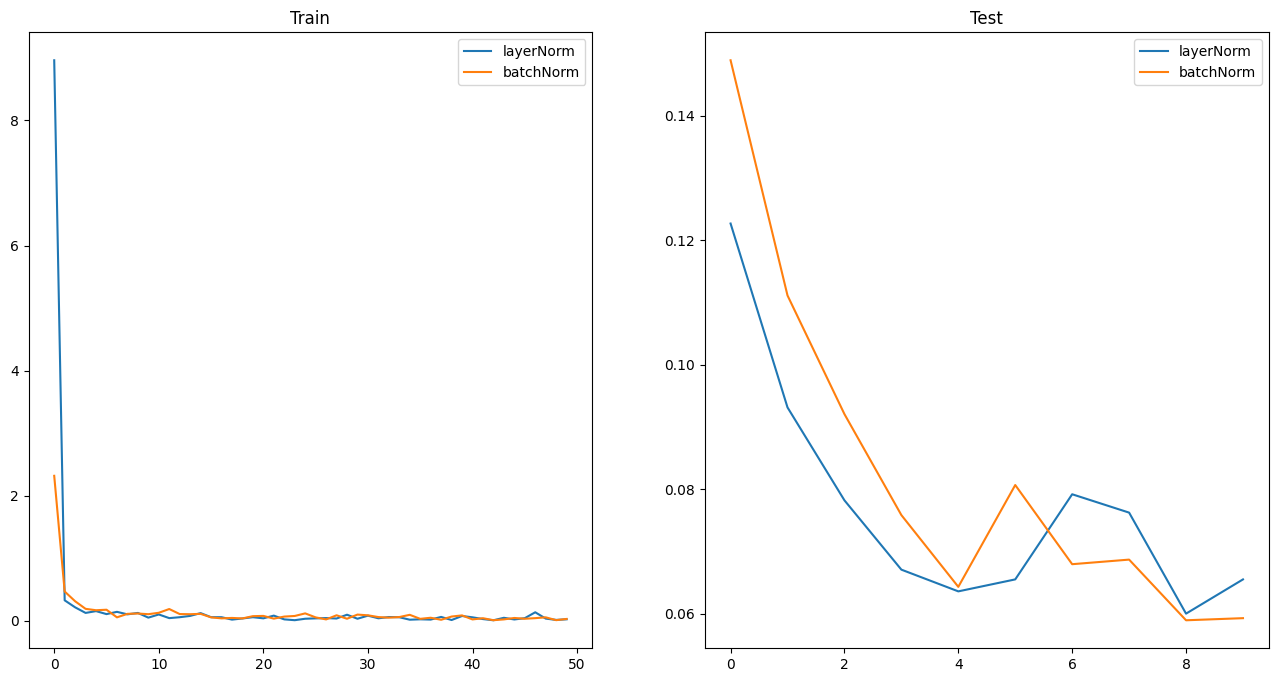

In [22]:
x1 = range(len(layerNorm_train_losses))
x2 = range(len(layerNorm_test_losses))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(x1, layerNorm_train_losses, label='layerNorm')
ax1.plot(x1, batchNorm_train_losses, label='batchNorm')
ax1.set_title('Train')
ax1.legend()

ax2.plot(x2, layerNorm_test_losses, label='layerNorm')
ax2.plot(x2, batchNorm_test_losses, label='batchNorm')
ax2.set_title('Test')
ax2.legend()

plt.show()

Таким образом, результаты batchNorm и layerNorm в целом сопоставимы, но на тесте в данном случае batchNorm показывает результат немного лучше и стабильнее, чем layerNorm.